In [1]:
from datetime import datetime,timedelta
DATES=["20141001","20141002","20141003","20141006","20141007","20141008","20141009","20141010","20141013","20141014","20141015"]

import pandas as pd
pd.options.display.float_format = '{:20,.2f}'.format

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np
%matplotlib inline

import math
from collections import Counter

# Control Period 1
The first point of comparison is to compare [09:30-09:33) on Oct 15 to the same time interval of every proceeding weekday in our dataset (1 Oct-14 Oct)

In [2]:

#Number of MFCs between 09:30:00 and 09:33:00
START_TIME=datetime.strptime("09:30:00.0","%H:%M:%S.%f").time() #Greater than or equal to this
END_TIME=datetime.strptime("09:33:00.0","%H:%M:%S.%f").time() #Strictly less than this

def get_time(str):
    format="%Y-%m-%d %H:%M:%S.%f" if "." in str else "%Y-%m-%d %H:%M:%S"
    return datetime.strptime(str,format).time()

results=[]
#print("Date\tMFCs\tEquities")
for date in DATES:
    with open("../data/{}_miniflash_crashes.csv".format(date),"r") as fh:
        count=0
        equities=[]
        header=None
        for line in fh:
            fields=line.split(",")
            if header==None:
                header=fields
                continue
            start=get_time(fields[header.index("start_time")])
            end=get_time(fields[header.index("end_time")])
            if start>=START_TIME and end<END_TIME:
                count+=1
                equities.append(fields[header.index("symbol")])
    #print("{}\t{}\t{}".format(date,count,len(set(equities))))
    results.append([date,count,len(set(equities))])
df_mfcs=pd.DataFrame(results, columns=["date","mfcs","equities"])    
df_mfcs

,date,mfcs,equities
0,20141001,1,1
1,20141002,3,3
2,20141003,0,0
3,20141006,2,2
4,20141007,2,2
5,20141008,5,5
6,20141009,1,1
7,20141010,3,3
8,20141013,3,3
9,20141014,5,4


In [3]:
df_volume=pd.read_csv("../data/trade_volume.csv",sep="\t",dtype={"date":"str"})
df_volume

,date,trades_09:30-09:33
0,20141001,354394
1,20141002,357221
2,20141003,364482
3,20141006,377942
4,20141007,368060
5,20141008,320907
6,20141009,354617
7,20141010,593973
8,20141013,376676
9,20141014,444223


In [4]:
#This is Table 1 in the article.
df = df_mfcs.merge(df_volume,on="date")
df["mfcs_per_trade"]=df["trades_09:30-09:33"]/df["mfcs"]
df

,date,mfcs,equities,trades_09:30-09:33,mfcs_per_trade
0,20141001,1,1,354394,"354,394.00"
1,20141002,3,3,357221,"119,073.67"
2,20141003,0,0,364482,inf
3,20141006,2,2,377942,"188,971.00"
4,20141007,2,2,368060,"184,030.00"
5,20141008,5,5,320907,"64,181.40"
6,20141009,1,1,354617,"354,617.00"
7,20141010,3,3,593973,"197,991.00"
8,20141013,3,3,376676,"125,558.67"
9,20141014,5,4,444223,"88,844.60"


In [5]:
x=df.copy()
x=x[x.date!="20141015"]
x=x.describe()
mfcs_mean=x["mfcs"]["mean"]
mfcs_3sd=mfcs_mean+3*x["mfcs"]["std"]
equities_mean=x["equities"]["mean"]
equities_3sd=equities_mean+3*x["equities"]["std"]
x

,mfcs,equities,trades_09:30-09:33,mfcs_per_trade
count,10.00,10.00,10.00,10.00
mean,2.50,2.40,"391,249.50",inf
std,1.65,1.51,"77,712.44",nan
min,0.00,0.00,"320,907.00","64,181.40"
25%,1.25,1.25,"355,268.00","120,694.92"
50%,2.50,2.50,"366,271.00","186,500.50"
75%,3.00,3.00,"377,625.50","315,293.25"
max,5.00,5.00,"593,973.00",inf


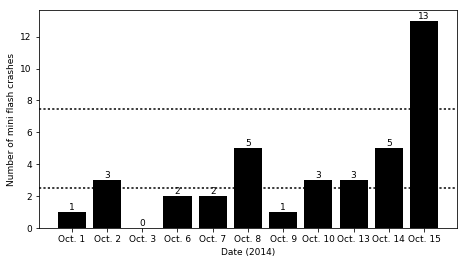

In [6]:
#Figure 1
matplotlib.rcParams.update({'font.size': 9})
dates=df.date.apply(lambda x: "Oct. {}".format(int(x[-2:])))

fig, ax = plt.subplots(figsize=(7.5,4))
rects=ax.bar(df.index, df.mfcs, color='black')
plt.xlabel("Date (2014)")
plt.ylabel("Number of mini flash crashes")
plt.xticks(df.index,dates )
plt.axhline(y=mfcs_mean, color='black', linestyle=':')
plt.axhline(y=mfcs_3sd, color='black', linestyle=':')

for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height,'%d' % int(height),ha='center', va='bottom')
#plt.show()
plt.savefig("mfcs.svg")

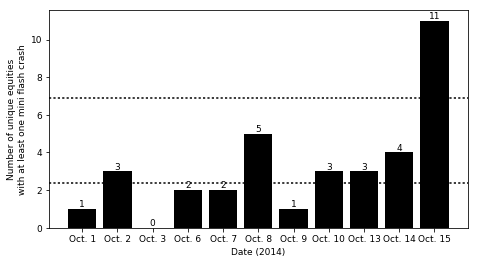

In [7]:
#Figure 2
matplotlib.rcParams.update({'font.size': 9})
dates=df.date.apply(lambda x: "Oct. {}".format(int(x[-2:])))

fig, ax = plt.subplots(figsize=(7.5,4))
rects=ax.bar(df.index, df.equities, color='black')
plt.xlabel("Date (2014)")
plt.ylabel("Number of unique equities\nwith at least one mini flash crash")
plt.xticks(df.index,dates )
plt.axhline(y=equities_mean, color='black', linestyle=':')
plt.axhline(y=equities_3sd, color='black', linestyle=':')

for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height,'%d' % int(height),ha='center', va='bottom')
#plt.show()
plt.savefig("equities.svg")

# Control Period 2
Now we compare [09:30-09:33) on Oct. 15 to all three minute windows [09:30-16:00) on the proceeding weekdays.

In [8]:
START_TIME=datetime.strptime("09:30:00.0","%H:%M:%S.%f") #Greater than or equal to this
END_TIME=datetime.strptime("16:00:00.0","%H:%M:%S.%f")#Strictly less than this

def get_time(str):
    str=str[11:] #Chop off year
    format="%H:%M:%S.%f" if "." in str else "%H:%M:%S"
    return datetime.strptime(str,format)

#three_minute_windows={}
#x=START_TIME
#while x<END_TIME-timedelta(minutes=2):
#    three_minute_windows[x]=0
#    x+=timedelta(minutes=1)

WINDOWS_PER_DAY=388
        
results=[]
for date in DATES:
    if date=="20141015": continue
    three_minute_windows=[0 for x in range(1,WINDOWS_PER_DAY+1)]
    assert len(three_minute_windows)==WINDOWS_PER_DAY

    with open("../data/{}_miniflash_crashes.csv".format(date),"r") as fh:
        count=0
        equities=[]
        header=None
        for line in fh:
            fields=line.split(",")
            if header==None:
                header=fields
                continue
            start=get_time(fields[header.index("start_time")])
            end=get_time(fields[header.index("end_time")])
            if start<START_TIME or end>END_TIME:
                continue
            
            x=(start-START_TIME).total_seconds()/60
            x=math.floor(x) if x>math.floor(x) else math.floor(x)-1
            #Each MFC is part of up to three, three-minute windows
            if x<WINDOWS_PER_DAY:
                three_minute_windows[x]+=1
            if x-1>=0 and x-1<WINDOWS_PER_DAY:
                three_minute_windows[x-1]+=1
            if x-2>=0 and x-2<WINDOWS_PER_DAY:
                three_minute_windows[x-2]+=1
    print(date,Counter(three_minute_windows))
    results.append(three_minute_windows)

big_list=[]
for l in results:
    big_list+=l
big_list.append(df[df.date=="20141015"]["mfcs"]) #Append the count for the 09:30-09:33 window on Oct 15


hist=np.bincount(np.array(big_list))
print(sum(hist))
assert sum(hist)==WINDOWS_PER_DAY*(len(DATES)-1)+1

print(hist)
    

20141001 Counter({0: 325, 1: 41, 2: 19, 3: 3})
20141002 Counter({0: 310, 1: 62, 2: 14, 3: 1, 4: 1})
20141003 Counter({0: 358, 1: 27, 3: 3})
20141006 Counter({0: 343, 1: 42, 2: 3})
20141007 Counter({0: 332, 1: 48, 2: 7, 3: 1})
20141008 Counter({0: 310, 1: 64, 2: 10, 3: 3, 5: 1})
20141009 Counter({0: 301, 1: 75, 2: 7, 3: 5})
20141010 Counter({0: 278, 1: 84, 2: 20, 3: 6})
20141013 Counter({0: 312, 1: 60, 2: 8, 3: 4, 4: 4})
20141014 Counter({0: 293, 1: 68, 2: 23, 3: 3, 5: 1})
3881
[3162  571  111   29    5    2    0    0    0    0    0    0    0    1]


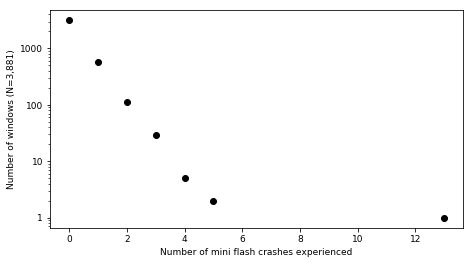

In [9]:
#Figure 3
matplotlib.rcParams.update({'font.size': 9})

vals=np.array(hist,dtype=np.double)
vals[vals==0 ] = np.nan

fig, ax = plt.subplots(figsize=(7.4,4))
ax.scatter(range(0,len(vals)), vals, color='black')
plt.xlabel("Number of mini flash crashes experienced")
plt.ylabel("Number of windows (N=3,881)")
ax.set_yscale("log", nonposx='clip')
ax.yaxis.set_major_formatter(ScalarFormatter())
#plt.show()
plt.savefig("control_period2.svg")